In [89]:
import pickle
import matplotlib.pyplot as plt
import numpy as np  

data = pickle.load(open('data_and_label.pkl', "rb"))
traj, label = data[0]

878 471 125


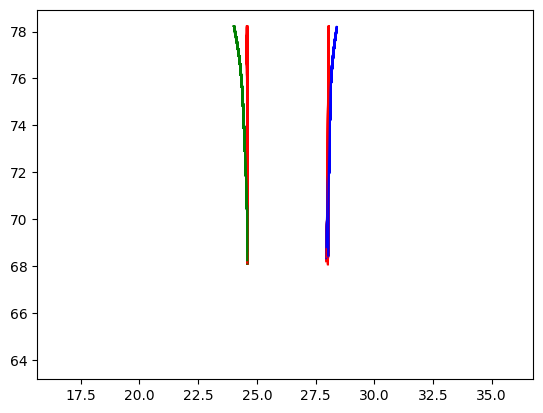

In [90]:
s, l, r = 0, 0, 0
data_new = []
for i in range(len(data)):
    traj, label = data[i]
    traj = np.array(traj)
    
    if label == 1:
        plt.plot(traj[:, 0], traj[:, 1], 'r')
        s += 1
        if s <= 200:
            data_new.append(data[i])
    elif label == 0:
        plt.plot(traj[:, 0], traj[:, 1], 'g')
        l += 1
        if l <= 200:
            data_new.append(data[i])
    elif label == 2:
        plt.plot(traj[:, 0], traj[:, 1], 'b')
        r += 1
        if r <= 125:
            data_new.append(data[i])
    else:
        print('error')
print(s, l, r)

plt.axis('equal')

pickle.dump(data_new, open('data_and_label_new.pkl', "wb"))

In [83]:
data = pickle.load(open('test_data.pkl', "rb"))
traj, label = data[0]

In [84]:
len(data)

105

In [85]:
import torch

a, b, c = 0, 0, 0
for i in range(len(data)):
    traj, label = data[i]
    if torch.all(label == torch.tensor([1, 0, 0])):
        a += 1
    elif torch.all(label == torch.tensor([0, 1, 0])):
        b += 1
    elif torch.all(label == torch.tensor([0, 0, 1])):
        c += 1
        
print(a, b, c)

In [4]:
import numpy as np  
np.array(traj).shape

(20, 3)

In [11]:
label

tensor([1, 0, 0])

In [51]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

torch.cuda.set_device(0)

device = 'cuda'
batch_size = 32
num_epochs = 600


class CarlaDataset(Dataset):
    def __init__(self):
        self.data = pickle.load(open('data_and_label.pkl', "rb"))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        traj, label = self.data[index]
        traj = torch.tensor(np.array(traj))   # shape=(20,3)
        if label == 0:
            label = [1, 0, 0]
        elif label == 1:
            label = [0, 1, 0]
        else:
            label = [0, 0, 1]
        label = torch.tensor(label)
        return traj, label

dataset = CarlaDataset()

# 划分数据集
train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=5) 
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)




In [68]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)
        self.fc4 = nn.Linear(3, 64)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)
        ctr = x[:, -1]
        ctr_feature = self.fc4(ctr)
        
        x = x.view(-1, 60)
        batch_size = x.size(0)
        sequence_length = x.size(1)
        x = x.view(batch_size, sequence_length, 1)
        
        # Apply LSTM
        h0 = torch.zeros(2, batch_size, 64).to(x.device)  # Initial hidden state
        c0 = torch.zeros(2, batch_size, 64).to(x.device)  # Initial cell state
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Reshape and pass through linear layers
        lstm_out = lstm_out[:, -1, :]  # Take the last time step output
        x = self.relu(lstm_out)
        x = self.fc1(x)
        result_tensor = torch.cat((x, ctr_feature), dim=1)

        x = self.relu(result_tensor)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        x = F.softmax(x, dim=1)
        
        return x

model = Net().to(device)

In [69]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

log_file = open("log.txt", "w")
# 训练模型
for epoch in range(num_epochs):
    for trajs, labels in train_dataloader:
        trajs = trajs.to(device).float()
        labels = labels.to(device).float()
        model.train()
        outputs = model(trajs).squeeze()
        break
    break

In [93]:
test_data = pickle.load(open('test_data.pkl', "rb"))
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

size = len(test_dataloader.dataset)
num_batches = len(test_dataloader)
model.eval().to(device)
test_loss, correct = 0, 0
with torch.no_grad():
    for trajs, labels in test_dataloader:
        trajs, labels = trajs.to(device).float(), labels.to(device).float()
        pred = model(trajs)

        test_loss += loss_fn(pred, labels)
        _, predicted_labels = torch.max(pred, dim=1)
        _, labels = torch.max(labels, dim=1)

        correct += (predicted_labels == labels).sum().item()
print(correct/len(test_dataloader.dataset))

0.37142857142857144


In [94]:
predicted_classes = torch.argmax(pred, dim=1)
print(predicted_classes)
print(labels)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
tensor([0, 0, 2, 2, 1, 1, 0, 0, 2], device='cuda:0')
